In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
log_dir = f"{logs}/resultats_11-23/"
save_dir = f"{processed_log_dir}/rnnt/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_58219/2251646923.py:9: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [3]:
len(jobs)

17

In [4]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'sub_seed', 'srun_start_time_ms', 'start_time_ms',
       'training_start_time_ms', 'cmd_batch_size', 'cmd_beta1', 'cmd_beta2',
       'cmd_max_duration', 'cmd_val_batch_size', 'cmd_target', 'cmd_lr',
       'cmd_min_lr', 'cmd_lr_exp_gamma', 'cmd_epochs', 'cmd_warmup_epochs',
       'cmd_hold_epochs', 'cmd_epochs_this_job', 'cmd_ema', 'cmd_model_config',
       'cmd_dataset_dir', 'cmd_weight_decay', 'cmd_log_frequency',
       'cmd_val_frequency', 'cmd_grad_accumulation_steps',
       'cmd_prediction_frequency', 'cmd_weights_init_scale',
       'cmd_val_manifests', 'cmd_num_buckets', 'cmd_max_symbol_per_sample',
       'cmd_apex_transducer_loss', 'cmd_apex_transducer_joint', 'cmd_fc_impl',
       'cmd_ema_update_type', 'train_end_time_ms', 'end_time_ms', 'epoch_nb',
       'block_nb', 'eval_nb', 'mllog_seed',
       'mllog_gradient_accumulation_steps', 'ml

In [5]:
job_list = list(jobs.job_id)
np.array(job_list)

array([126701, 126702, 126703, 126704, 126705, 126706, 126707, 126708,
       126709, 126710, 126711, 126712, 126713, 126714, 126715, 126716,
       126717])

In [6]:
def plot_energy_components(ax ,energy_df, node, energy_col, legend=False):
    for label, df in energy_df.groupby(["device_index"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label="GPU energy "+str(label),
            )
    for label, df in energy_df.groupby(["domain", "socket"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label=label,
            )
    if legend:
        ax.legend(
            bbox_to_anchor=(0.5,-0.1), 
            loc='upper center',
            fontsize=20,
            ncol=2
        )
    else:
        ax.get_legend().remove()
    ax.set_title(node)
    return ax

def plot_utilization(ax, plot_df):
    plot_df[
        (plot_df["device_index"].notna())
        
        ].plot(x="timestamp", y="global_utilization_percent", ax=ax, label="GPU utilization")
    plot_df[
        (plot_df["device_index"].notna())
        ].plot(x="timestamp", y="global_memory_percent", ax=ax, label="GPU mem utilization")
    plot_df[
        (plot_df["utilization_percent"].notna())
        ].groupby("timestamp").mean().plot(ax=ax, y="utilization_percent", label="CPU avg utilization")
    # ax.legend(
    #     bbox_to_anchor=(0.5,-0.1), 
    #     loc='upper center',
    #     fontsize=20,
    #     ncol=2
    # )
    ax.get_legend().remove()
    return ax



In [7]:
max_y = 0
max_x = 0
for job in job_list:
    energy_df = energy[energy["job"]==job]
    max_job_energy = energy_df["energy_consumption_since_previous_measurement_milliJ"].max()
    max_job_time = energy_df["timestamp"].max() - energy_df["timestamp"].min()
    if max_y<max_job_energy:
        max_y=max_job_energy
    if max_x<max_job_time:
        max_x=max_job_time
max_x, max_y

(2474311, 628032.0)

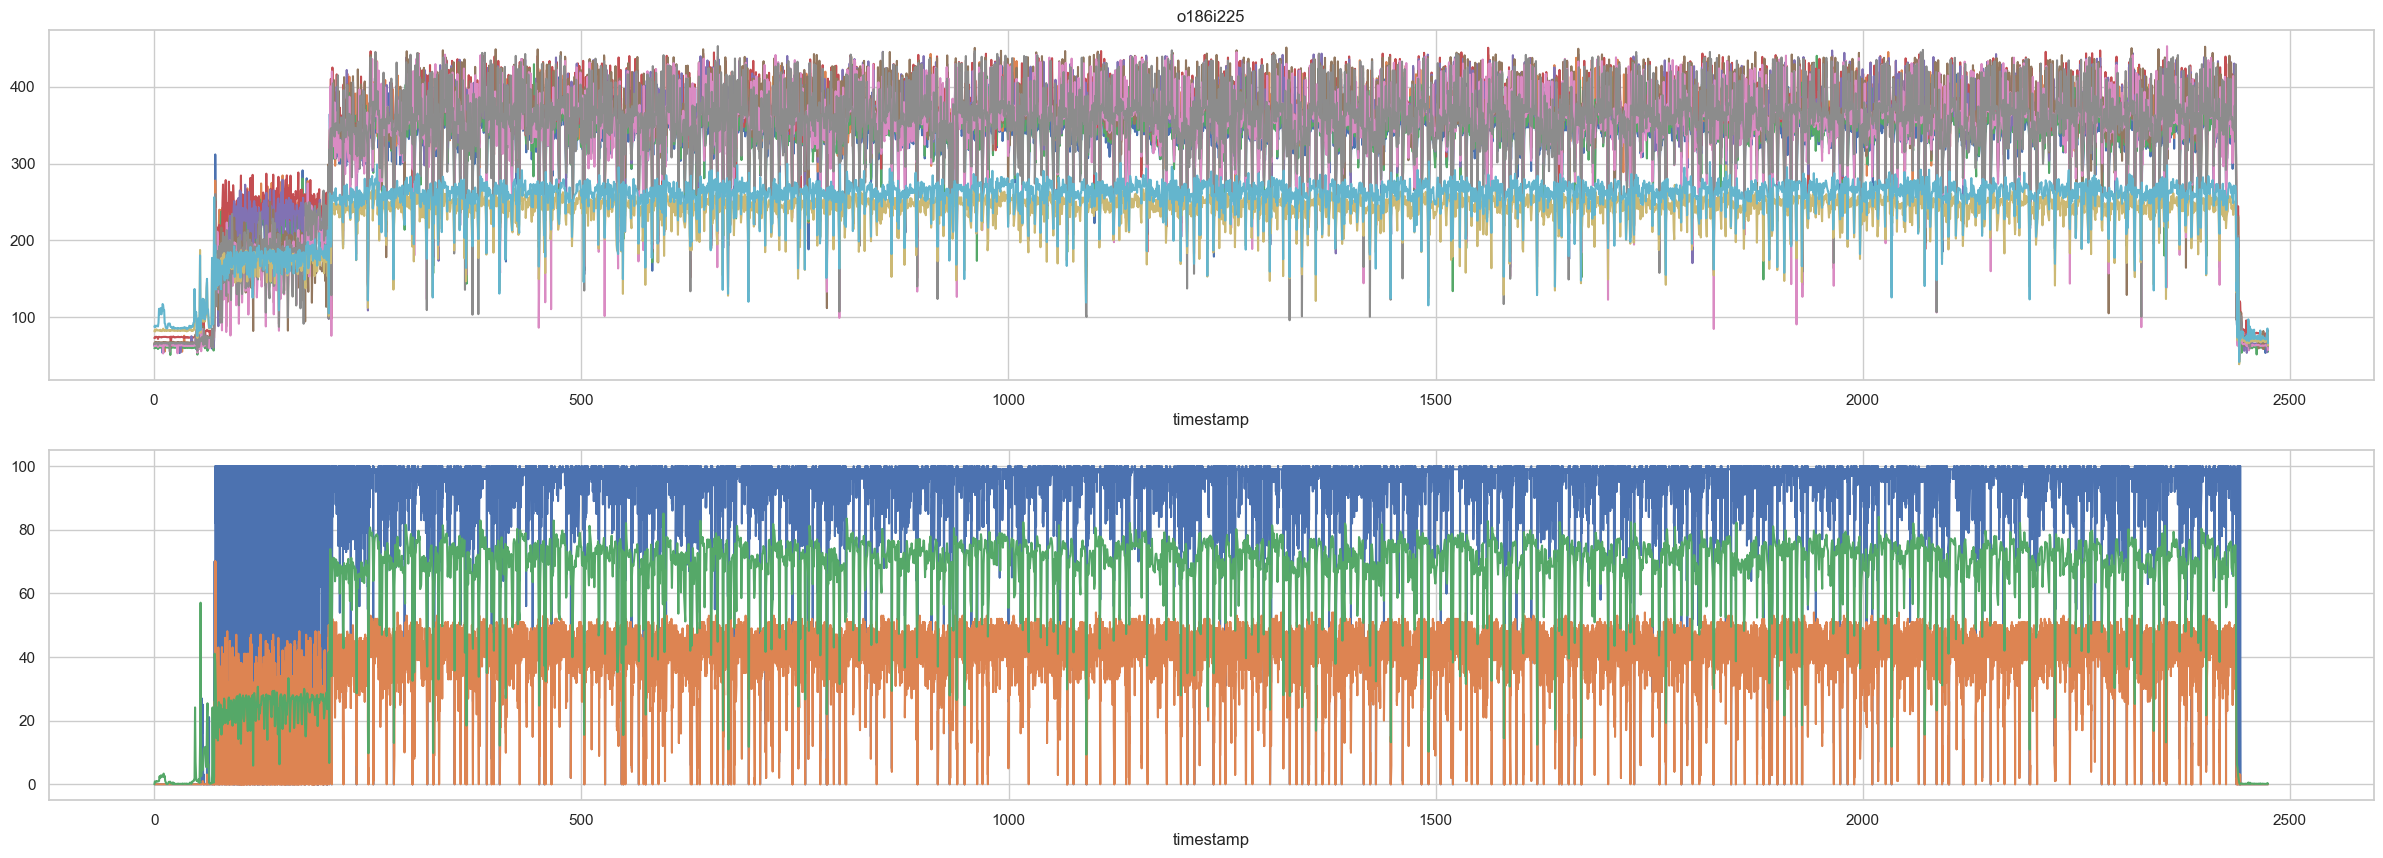

In [8]:


for job in job_list[:1]:
    energy_job = energy[energy["job"]==job]
    nodes = energy_job.node.unique()
    node_nb = len(nodes)
    # batch, target, sample, seed = jobs[jobs["job"]==job][["total_batch_size", "sub_target-acc", "sub_num-sample", "sub_seed"]].values[0]
    fig, ax = plt.subplots(2, node_nb, figsize=(30,10))
    for i, node in enumerate(nodes):
        
        ax1 = ax[0,i] if node_nb>1 else ax[0]
        ax2 = ax[1,i] if node_nb>1 else ax[1]
        plot_df = energy_job[energy_job["node"]==node]
        
        avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
        diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
        diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
        diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
        avg_df = avg_df.merge(diff_df, on="timestamp")
        avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
        avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3

        ax1 = plot_energy_components(ax1, avg_df, node, 'power(W)')
        # ax1.set_ylim(0, max_y*1.5)
        # ax1.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
        ax2 = plot_utilization(ax2, avg_df)
        # ax2.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
    # plt.suptitle(f"Batch-size: {batch}, target: {target}, sample nb: {sample}, seed: {seed}")

In [9]:
# Let's

# Let's aggregate the results


<!-- avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
avg_df = avg_df.merge(diff_df, on="timestamp")
avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3 -->

   

In [10]:
energy.describe()

,timestamp,device_index,energy_consumption_since_previous_measurement_milliJ,instantaneous_power_milliW,global_utilization_percent,global_memory_percent,job,socket,utilization_percent,energy_joule,energy_kWh,timestamps_msec
count,8.263490e+06,478920.00000,598650.000000,478920.000000,478920.000000,478920.000000,8.263490e+06,119730.000000,7.664840e+06,598650.000000,598650.000000,8.263490e+06
mean,1.699483e+12,3.50000,203334.754512,338716.136518,91.911716,37.982118,1.267088e+05,0.500000,6.589167e+01,203.334755,0.000056,1.079373e+06
std,1.129305e+07,2.29129,53601.288643,99459.708800,22.898425,13.162118,4.926154e+00,0.500002,2.116577e+01,53.601289,0.000015,6.565114e+05
min,1.699464e+12,0.00000,30041.000000,59644.000000,0.000000,0.000000,1.267010e+05,0.000000,0.000000e+00,30.041000,0.000008,-4.668600e+04
25%,1.699474e+12,1.75000,170678.100586,316669.000000,98.000000,37.000000,1.267040e+05,0.000000,5.967742e+01,170.678101,0.000047,5.122690e+05
50%,1.699483e+12,3.50000,217994.500000,369946.000000,99.000000,42.000000,1.267090e+05,0.500000,7.142857e+01,217.994500,0.000061,1.075472e+06
75%,1.699493e+12,5.25000,231163.000000,403466.000000,99.000000,46.000000,1.267130e+05,1.000000,7.936508e+01,231.163000,0.000064,1.639144e+06
max,1.699503e+12,7.00000,628032.000000,522663.000000,100.000000,77.000000,1.267170e+05,1.000000,1.000000e+02,628.032000,0.000174,2.427625e+06


In [11]:
power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()
    
    power = pd.concat([power, power_job])


In [12]:
power

,timestamp,energy_consumption_since_previous_measurement_milliJ,job,timestamp(sec),power(W)
0,1699480544111,432050.624390,1267080,0.000,NaN
1,1699480544710,421873.942139,1267080,0.599,704.297065
2,1699480545309,423495.257446,1267080,1.198,707.003769
3,1699480545915,422654.490967,1267080,1.804,697.449655
4,1699480546519,421996.695679,1267080,2.408,698.670026
...,...,...,...,...,...
3282,1699502888204,404860.693726,1267170,2093.439,669.191229
3283,1699502888812,407045.644531,1267170,2094.047,669.482968
3284,1699502889415,410101.233521,1267170,2094.650,680.101548
3285,1699502890046,423576.651855,1267170,2095.281,671.278371


/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

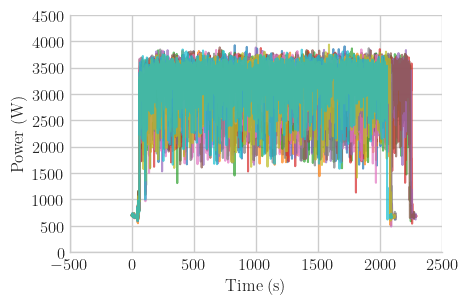

In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="timestamp(sec)", 
    y="power(W)", 
    data=power.reset_index(), 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )
# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set(ylim=(0, 4500))
ax.set_xlabels("Time (s)", fontsize=FONTSIZE)
ax.set_ylabels("Power (W)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/rnnt.png", dpi=300)

In [14]:
power = pd.DataFrame()
ilo_power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()   
    
    power = pd.concat([power, power_job])
    
    ilo_path = f"{log_dir}/rnnt/{job}/o186i225/ilo_power.csv" 
    ilo = pd.read_csv(ilo_path)
    ilo["job"]=job
    ilo["timestamp(sec)"] = (ilo["timestamp"]-power_job["timestamp"].min()*1e-3)
    ilo_power = pd.concat([ilo_power, ilo]) 

In [15]:
min = 200
max = 2000
avg_power = power[(power["timestamp(sec)"]>min)&(power["timestamp(sec)"]<max)].groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power[(ilo_power["timestamp(sec)"]>min)&(ilo_power["timestamp(sec)"]<max)].groupby(["job"])["power_watt"].mean().reset_index()


In [16]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,1.267125e+06,3330.913345
std,3.027650e+01,8.111454


In [17]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126712.50000,2549.828026
std,3.02765,9.272141


In [18]:
avg_power = power.groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power.groupby(["job"])["power_watt"].mean().reset_index()


In [19]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,1.267125e+06,3196.493069
std,3.027650e+01,8.399683


In [20]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126712.50000,2489.917699
std,3.02765,8.752936


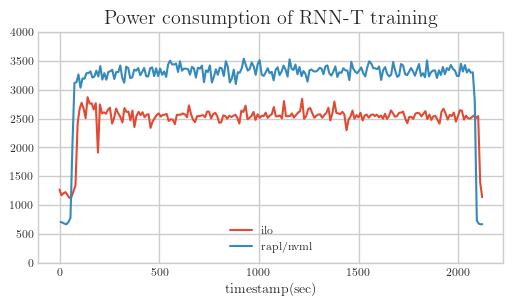

In [103]:
fig, ax = plt.subplots(figsize=(6,3))
jobid = 0

data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]]
data_ilo = data.set_index(pd.to_datetime(data["timestamp"], unit="s")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_ilo.resample("10s").mean()
# data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]].groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data_ilo, kind="line", label="ilo",height=6, aspect=15/8)
data_ilo.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")

data = power[power["job"]==power["job"].values[jobid]]
data = data.set_index(pd.to_datetime(data["timestamp"], unit="ms")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_power = data.resample("10s", origin=data_ilo.index[0]).mean()
# data_power = data_power.groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)") # "job", 
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data_power, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data_power.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")

ax.set(title="Power consumption of RNN-T training")
ax.set_ylim(0, 4000)
plt.savefig(f"{graph_dir}/ilo_rnnt.png", dpi=300)
plt.savefig(f"{graph_dir}/ilo_rnnt.pdf", dpi=300)
# ax._legend.remove()

<Axes: xlabel='power(W)', ylabel='power_watt'>

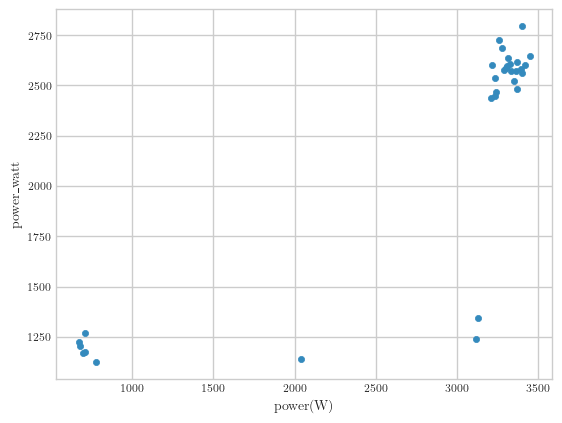

In [101]:
data_power.merge(data_ilo, on="timestamp").plot(x="power(W)", y="power_watt", kind="scatter")